# Import

In [19]:
import joblib
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

In [20]:
# carregar modelo
best_lgbm = joblib.load(r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\models\final_model.pkl')

# carregar base de teste pós-FE
df_test_fe = pd.read_csv(r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\data\processed\test_fe.csv')
df_train_fe = pd.read_csv(r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\data\processed\train_fe.csv')

# carregar features selecionadas
selected_features = joblib.load(r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\models\selected_features.pkl')

ID_COL = "id"
TIME_COL = "safra"
TARGET_COL = "y"

X_train = df_train_fe[selected_features].copy()
y_train = df_train_fe[TARGET_COL].copy()

X_test  = df_test_fe[selected_features].copy()
y_test  = df_test_fe[TARGET_COL].copy()

X_train.shape, X_test.shape

((8211, 20), (2527, 20))

In [21]:
def ks_score(y_true, y_proba) -> float:
    data = pd.DataFrame({"y": y_true, "score": y_proba}).sort_values(
        "score", ascending=False
    )

    total_bad = (data["y"] == 1).sum()
    total_good = (data["y"] == 0).sum()

    if total_bad == 0 or total_good == 0:
        return 0.0

    data["cum_bad"] = (data["y"] == 1).cumsum() / total_bad
    data["cum_good"] = (data["y"] == 0).cumsum() / total_good

    ks = (data["cum_bad"] - data["cum_good"]).abs().max()
    return float(ks)


def performance_metrics(y_true, y_proba, threshold: float = 0.5) -> dict:
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)
    y_pred = (y_proba >= threshold).astype(int)

    auc = roc_auc_score(y_true, y_proba)
    ks = ks_score(y_true, y_proba)
    gini = 2 * auc - 1

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "AUC": float(auc),
        "KS": float(ks),
        "Gini": float(gini),
        "Accuracy": float(acc),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1),
        "TP": int(tp),
        "TN": int(tn),
        "FP": int(fp),
        "FN": int(fn),
    }

def construct_metrics_table(df, quantil_col, score_col, target_col, ordered_labels):
    tabela = (
        df.groupby(quantil_col)
          .agg(
              volume=(target_col, "size"),
              event_rate=(target_col, "mean"),
              score_min=(score_col, "min"),
              score_max=(score_col, "max"),
          )
          .reset_index()
    )

    # garantir ordem dos rótulos
    tabela[quantil_col] = pd.Categorical(
        tabela[quantil_col],
        categories=ordered_labels,
        ordered=True,
    )
    tabela = tabela.sort_values(quantil_col)

    return tabela

def ks_safe(y_true, y_proba):
    y_arr = np.array(y_true)
    if (y_arr == 1).sum() == 0 or (y_arr == 0).sum() == 0:
        return np.nan
    return ks_score(y_true, y_proba)

# Métricas do modelo final

In [22]:
# Probabilidades
y_proba_train = best_lgbm.predict_proba(X_train)[:, 1]
y_proba_test  = best_lgbm.predict_proba(X_test)[:, 1]

metrics_train = performance_metrics(y_train, y_proba_train, threshold=0.5)
metrics_test  = performance_metrics(y_test,  y_proba_test,  threshold=0.5)

results_final = pd.DataFrame(
    [metrics_train, metrics_test],
    index=["Treino", "Teste"]
)

results_final[["AUC", "KS", "Gini", "Accuracy", "Precision", "Recall", "F1"]]


,AUC,KS,Gini,Accuracy,Precision,Recall,F1
Treino,0.954156,0.766016,0.908311,0.877847,0.904000,0.634283,0.745496
Teste,0.708333,0.313688,0.416665,0.694104,0.589041,0.158867,0.250242


# Curvas ROC e KS

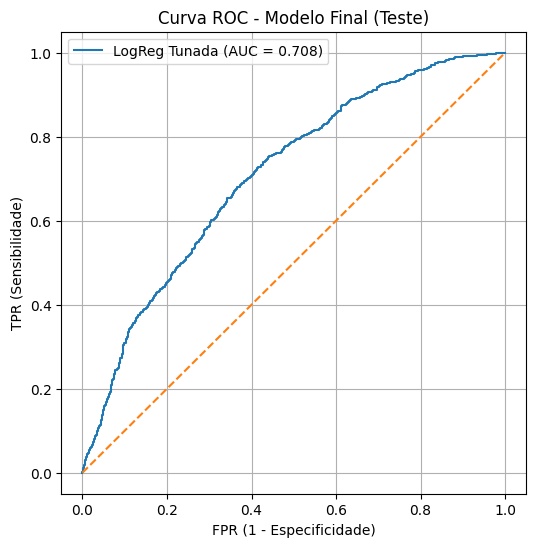

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"LogReg Tunada (AUC = {results_final.loc['Teste', 'AUC']:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR (1 - Especificidade)")
plt.ylabel("TPR (Sensibilidade)")
plt.title("Curva ROC - Modelo Final (Teste)")
plt.legend()
plt.grid(True)
plt.show()

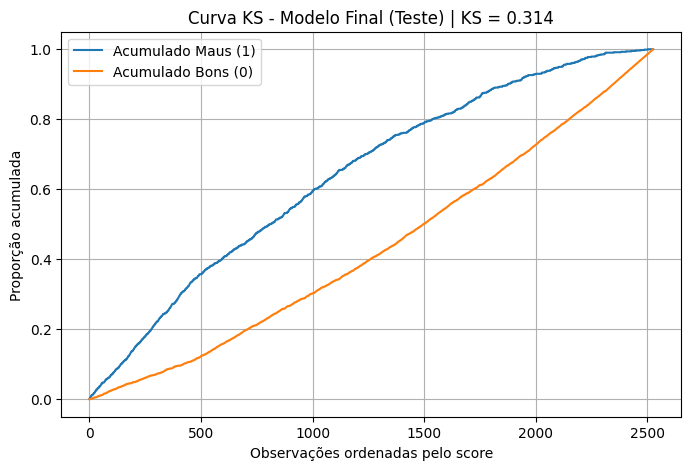

In [24]:
data_ks = pd.DataFrame({"y": y_test, "score": y_proba_test}).sort_values(
    "score", ascending=False
)

total_bad = (data_ks["y"] == 1).sum()
total_good = (data_ks["y"] == 0).sum()

data_ks["cum_bad"] = (data_ks["y"] == 1).cumsum() / total_bad
data_ks["cum_good"] = (data_ks["y"] == 0).cumsum() / total_good
data_ks["ks"] = (data_ks["cum_bad"] - data_ks["cum_good"])

ks_value = data_ks["ks"].abs().max()

plt.figure(figsize=(8, 5))
plt.plot(data_ks["cum_bad"].values, label="Acumulado Maus (1)")
plt.plot(data_ks["cum_good"].values, label="Acumulado Bons (0)")
plt.title(f"Curva KS - Modelo Final (Teste) | KS = {ks_value:.3f}")
plt.xlabel("Observações ordenadas pelo score")
plt.ylabel("Proporção acumulada")
plt.legend()
plt.grid(True)
plt.show()


# Scores

In [25]:
df_scores_train = df_train_fe[[ID_COL, TIME_COL, TARGET_COL]].copy()
df_scores_train["score"] = y_proba_train

df_scores_test = df_test_fe[[ID_COL, TIME_COL, TARGET_COL]].copy()
df_scores_test["score"] = y_proba_test

df_scores_train.head(), df_scores_test.head()

(   id   safra  y     score
 0   1  201404  0  0.021767
 1   2  201407  0  0.163036
 2   3  201405  0  0.478080
 3   5  201403  1  0.516809
 4   6  201405  0  0.464768,
    id   safra  y     score
 0   4  201412  0  0.191534
 1  13  201411  1  0.244756
 2  15  201412  0  0.335687
 3  17  201412  0  0.518169
 4  20  201411  0  0.145780)

In [26]:
# rótulos dos quantis
decile_labels = [f"Quantil_{i}" for i in range(1, 11)]

# cortes de score com base no treino
quantiles = df_scores_train["score"].quantile(np.linspace(0, 1, 11)).values

# garantir que os bins são estritamente crescentes
bins = np.unique(quantiles)
if len(bins) - 1 != 10:
    print("Aviso: alguns quantis colapsaram; você pode reduzir q ou aceitar menos faixas.")

# aplicar mesma discretização nos dois conjuntos
df_scores_train["quantil_score"] = pd.cut(
    df_scores_train["score"],
    bins=bins,
    labels=decile_labels[: len(bins) - 1],
    include_lowest=True,
)

df_scores_test["quantil_score"] = pd.cut(
    df_scores_test["score"],
    bins=bins,
    labels=decile_labels[: len(bins) - 1],
    include_lowest=True,
)

table_treino = construct_metrics_table(
    df_scores_train, "quantil_score", "score", "y", decile_labels
)
table_val = construct_metrics_table(
    df_scores_test, "quantil_score", "score", "y", decile_labels
)

C:\Users\Enrico\AppData\Local\Temp\ipykernel_36168\3867268354.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(quantil_col)
C:\Users\Enrico\AppData\Local\Temp\ipykernel_36168\3867268354.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(quantil_col)


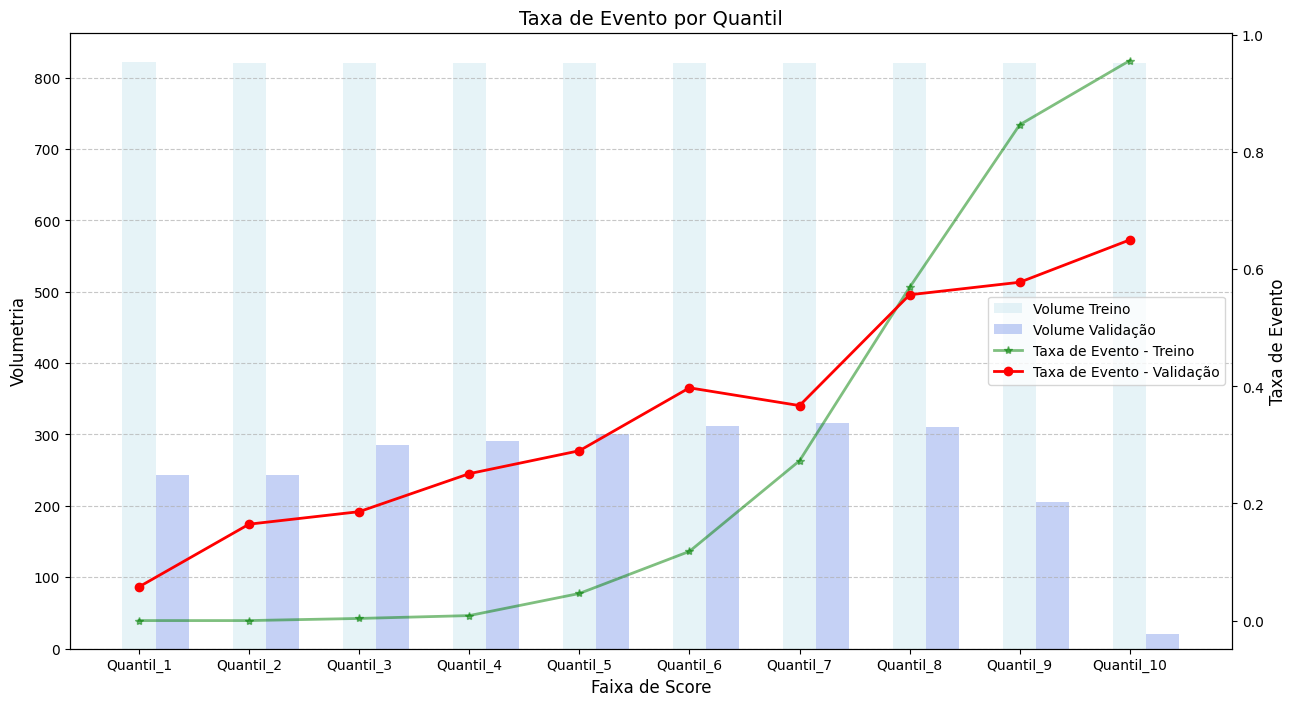

In [27]:
fig, ax1 = plt.subplots(figsize=(15, 8))

barWidth = 0.3
r1 = np.arange(len(table_treino["quantil_score"]))
r2 = r1 + barWidth

# Barras de volume
ax1.bar(
    r1,
    table_treino["volume"],
    color="lightblue",
    width=barWidth,
    alpha=0.3,
    label="Volume Treino",
)
ax1.bar(
    r2,
    table_val["volume"],
    color="royalblue",
    width=barWidth,
    alpha=0.3,
    label="Volume Validação",
)

ax1.set_ylabel("Volumetria", fontsize=12)
ax1.set_xlabel("Faixa de Score", fontsize=12)

# Eixo secundário para taxa de evento
ax2 = ax1.twinx()
ax2.plot(
    table_treino["quantil_score"],
    table_treino["event_rate"],
    color="green",
    marker="*",
    linewidth=2,
    alpha=0.5,
    label="Taxa de Evento - Treino",
)
ax2.plot(
    table_val["quantil_score"],
    table_val["event_rate"],
    color="red",
    marker="o",
    linewidth=2,
    label="Taxa de Evento - Validação",
)
ax2.set_ylabel("Taxa de Evento", fontsize=12)

# X ticks
ax1.set_xticks(np.arange(len(table_treino["quantil_score"])))
ax1.set_xticklabels(decile_labels[: len(table_treino)], ha="center")

plt.title("Taxa de Evento por Quantil", fontsize=14)
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# legenda combinada
fig.legend(loc="center right", bbox_to_anchor=(1, 0.5), bbox_transform=ax1.transAxes)

# opcional: salvar
# plt.savefig("../reports/taxa_evento_quantil.jpeg", dpi=120, bbox_inches="tight")

plt.show()

# Curva de calibração

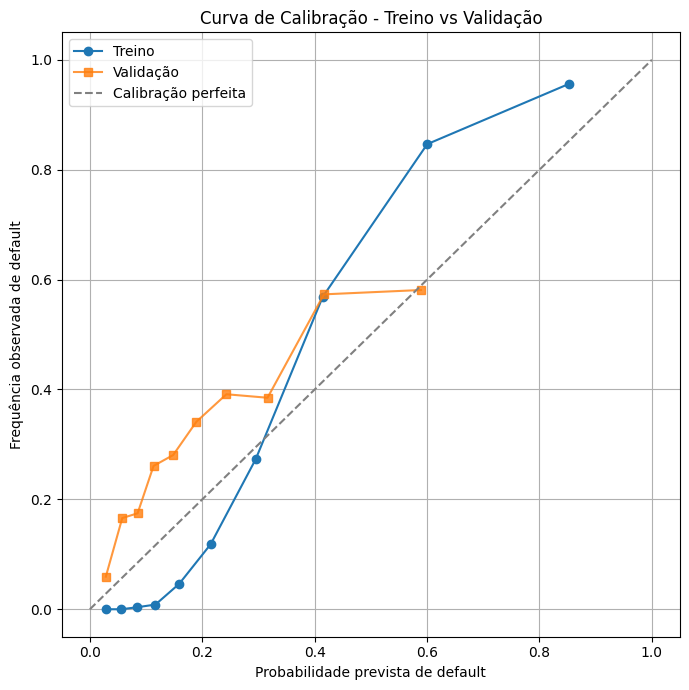

In [28]:
# Curva de calibração - TREINO
prob_true_tr, prob_pred_tr = calibration_curve(
    df_scores_train["y"],
    df_scores_train["score"],
    n_bins=10,
    strategy="quantile",   # bins com tamanhos parecidos
)

# Curva de calibração - VALIDAÇÃO (teste)
prob_true_te, prob_pred_te = calibration_curve(
    df_scores_test["y"],
    df_scores_test["score"],
    n_bins=10,
    strategy="quantile",
)

plt.figure(figsize=(7, 7))

plt.plot(prob_pred_tr, prob_true_tr, marker="o", label="Treino")
plt.plot(prob_pred_te, prob_true_te, marker="s", label="Validação", alpha=0.8)

# linha de perfeita calibração
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Calibração perfeita")

plt.xlabel("Probabilidade prevista de default")
plt.ylabel("Frequência observada de default")
plt.title("Curva de Calibração - Treino vs Validação")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# KS por safra

In [29]:
# KS por safra no TREINO
ks_safra_train = (
    df_scores_train
      .groupby("safra")
      .apply(lambda g: ks_safe(g["y"], g["score"]))
      .reset_index(name="KS_Treino")
)

# KS por safra na VALIDAÇÃO
ks_safra_test = (
    df_scores_test
      .groupby("safra")
      .apply(lambda g: ks_safe(g["y"], g["score"]))
      .reset_index(name="KS_Validacao")
)

# juntar numa tabela só
ks_safra = ks_safra_train.merge(ks_safra_test, on="safra", how="outer").sort_values("safra")
ks_safra

C:\Users\Enrico\AppData\Local\Temp\ipykernel_36168\2942522271.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ks_safe(g["y"], g["score"]))
C:\Users\Enrico\AppData\Local\Temp\ipykernel_36168\2942522271.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ks_safe(g["y"], g["score"]))


,safra,KS_Treino,KS_Validacao
0,201401,0.779812,NaN
1,201402,0.778869,NaN
2,201403,0.782354,NaN
3,201404,0.747870,NaN
4,201405,0.787559,NaN
5,201406,0.804128,NaN
6,201407,0.791736,NaN
7,201408,0.752214,NaN
8,201409,0.782267,NaN
9,201410,NaN,0.353682


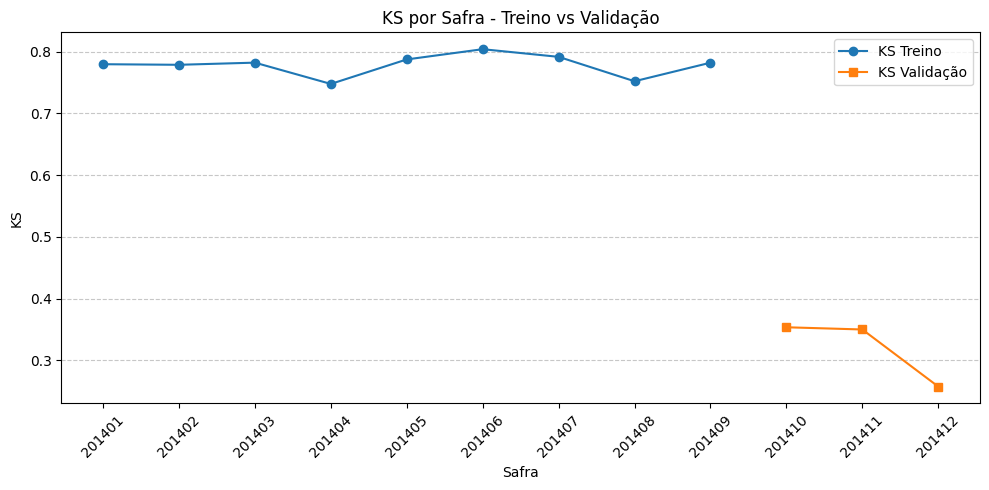

In [30]:
plt.figure(figsize=(10, 5))

x = ks_safra["safra"].astype(str)

plt.plot(x, ks_safra["KS_Treino"], marker="o", label="KS Treino")
plt.plot(x, ks_safra["KS_Validacao"], marker="s", label="KS Validação")

plt.xlabel("Safra")
plt.ylabel("KS")
plt.title("KS por Safra - Treino vs Validação")
plt.xticks(rotation=45)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()